In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl

In [ ]:
def print_info(df:pd.DataFrame, col_name):
    temp = '=' * 10 + ' [' + col_name + '] ' + '=' * 10
    print(temp)
    print(f'데이터 타입: {df[col_name].dtype}')
    print(f'결측치 수, 결측치의 비율: {df[col_name].isna().sum()}, {(df[col_name].isna().sum() / df[col_name].shape[0] * 100)}')


    plt.figure(figsize=(6,4))

    if df[col_name].dtype != 'object':
        print(f"(null, 0, >0) = {df[col_name].isna().sum(), (df[col_name] == 0.0).sum(), (df[col_name] > 0.0).sum()}")
        print(f'(min, max): ({df[col_name].dropna().min()}, {df[col_name].dropna().max()})')
        print(f'평균값: {df[col_name].dropna().mean()}')
        print(f'중간값: {df[col_name].dropna().median()}')
        print('=' * len(temp))

        # min 이 음수일 경우
        if df[col_name].dropna().min() < 0:
          temp = df[col_name].dropna() + np.ceil(np.abs(df[col_name]))
        else:
          temp = df[col_name].dropna()

        # 최댓값이 크면 log 변환, 최솟값이 0인 경우 (로그를 씌우면 -inf로 가기 때문에) 10으로 치환
        if np.log1p(temp.max()) - np.log1p(temp.min()) > 0.1:
        #if np.log10(temp.max()) - np.log10(max(temp.min(), 10)) > 3:
            log_temp = np.log1p(temp)
            #log_temp = np.log10(temp)
            #log_temp2 = np.log10(temp + 10)
            sns.kdeplot(log_temp, palette='Blues_r', )
            #sns.kdeplot(log_temp2, palette='Blues_r', )
            plt.xlabel('log converted value')
        else:
            sns.kdeplot(df[col_name], palette='Blues_r', )

        plt.title(col_name)
        plt.show()
    else:
				# 날짜 데이터인 경우
        try:
            # 날짜 데이터가 크다면(500개 이상) 연도별 데이터로 변환하기
            if len(df[col_name].value_counts()) > 500:
                df_datetime = pd.DataFrame(pd.to_datetime(df[col_name]).dt.year).value_counts().reset_index()
            else:
                df_datetime = pd.DataFrame(pd.to_datetime(df[col_name])).value_counts().reset_index()

            df_datetime.columns = ['date', 'count']
            df_datetime = df_datetime.set_index('date').sort_index()

            print(f'최솟값: {df_datetime.idxmin().values[0]} | {df_datetime.min().values[0]}')
            print(f'최댓값: {df_datetime.idxmax().values[0]} | {df_datetime.max().values[0]}')

            print('- - ' * 5)
            print('value_counts:')
            print(df[col_name].value_counts())
            print('- - ' * 5)
            print('=' * len(temp))

            sns.barplot(data=df_datetime['count'], palette='Blues', )
            x_ticks_interval = int(len(df_datetime['count']) / 10)
            plt.xticks(range(0, len(df_datetime['count']), x_ticks_interval), rotation=90)
            plt.title(col_name)
            plt.show()

        # 날짜 데이터로 변환이 불가능한 경우
        except:
            print(f'(min, max): ({df[col_name].dropna().min()}, {df[col_name].dropna().max()})')

            print('- - ' * 5)
            print('value_counts:')
            print(df[col_name].value_counts())
            print('- - ' * 5)
            print('=' * len(temp))

						# 카테고리가 10개를 넘는다면 5개만을 뽑아서 시각화
            if len(df[col_name].value_counts()) > 10:
                slice = 5
            else:
                slice = len(df[col_name])

            sns.countplot(data=df, x=col_name, order=df[col_name].value_counts()[:slice].index, palette='Blues_r', )
            plt.xticks(rotation=90, ha='right')
            plt.title(col_name)
            plt.show()

In [ ]:
parquet_f = r"/content/drive/MyDrive/Colab Notebooks/Upstage_AI_LAB/ML/ML_Project/data/"
df_tax_a1 = pl.read_parquet(parquet_f+"train/train_tax_registry_a_1.parquet").to_pandas()
df_tax_b1 = pl.read_parquet(parquet_f+"train/train_tax_registry_b_1.parquet").to_pandas()
df_tax_c1 = pl.read_parquet(parquet_f+"train/train_tax_registry_c_1.parquet").to_pandas()

# train_tax_registry
- 아래 3가지로 a, b, c file을 합쳐 사용하는게 더 편할 것 같음 -> 목차 `a / b / c 공통 유형 컬럼`

- 세금 공제 금액
  > amount_4527230A / amount_4917619A / pmtamount_36A
  - (a, c의 범위 - b의 범위) 다름
  
- 세금 공제 날짜
  > recorddate_4527225D / deductiondate_4917603D / processingdate_168D
  - 기록 날짜, 실제 공제된 날짜, 처리 날짜 약간의 의미는 다르지만 같이 봐도 무방할 듯
  - a(주로 2019), b (2019-2020) - c (2018-2019)

- employee 이름
  > name_4527232M / name_4917606M / employername_160M

- 의의:
  - 세금 공제 금액은 고객의 소득과 세금 납부 능력을 나타내는 지표
  - 개인의 세금 납부 패턴과 정기성을 파악하는 데 유용

# train_tax_registry_a_1

In [ ]:
df_tax_a1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275770 entries, 0 to 3275769
Data columns (total 5 columns):
 #   Column               Dtype  
---  ------               -----  
 0   case_id              int64  
 1   amount_4527230A      float64
 2   name_4527232M        object 
 3   num_group1           int64  
 4   recorddate_4527225D  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 125.0+ MB


In [ ]:
df_tax_a1.case_id.value_counts()

1709323    99
1748469    91
1609436    76
1604411    68
949395     68
           ..
923899      1
924029      1
924053      1
924130      1
940577      1
Name: case_id, Length: 457934, dtype: int64

In [ ]:
df_tax_a1.num_group1.value_counts()

0     457934
1     441416
2     426953
3     409203
4     388239
       ...  
95         1
93         1
97         1
98         1
92         1
Name: num_group1, Length: 99, dtype: int64

## amount_4527230A
- Tax deductions amount tracked by the government registry.
- 정부 레지스트리에서 추적하는 세금 공제 금액

========== [amount_4527230A] ==========
데이터 타입: float64
결측치 수, 결측치의 비율: 0, 0.0
(null, 0, >0) = (0, 165, 3275605)
(min, max): (0.0, 87115.6)
평균값: 2360.421375819258
중간값: 1400.0


<ipython-input-2-e54903270e3f>:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(log_temp, palette='Blues_r', )


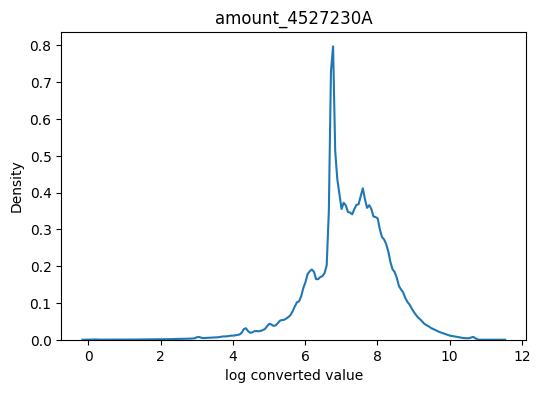

In [ ]:
print_info(df_tax_a1, df_tax_a1.columns[1])

## name_4527232M
- Name of employer.

========== [name_4527232M] ==========
데이터 타입: object
결측치 수, 결측치의 비율: 0, 0.0
(min, max): (000025c1, ffffa404)
- - - - - - - - - - 
value_counts:
5e180ef0        204371
P114_118_163     15751
74ca9587         13196
7444479d         12313
P157_88_183      10025
                 ...  
6365d73f             1
9ea5c4a5             1
edef2e86             1
190590e1             1
8a3a78cb             1
Name: name_4527232M, Length: 147037, dtype: int64
- - - - - - - - - - 


<ipython-input-2-e54903270e3f>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col_name, order=df[col_name].value_counts()[:slice].index, palette='Blues_r', )


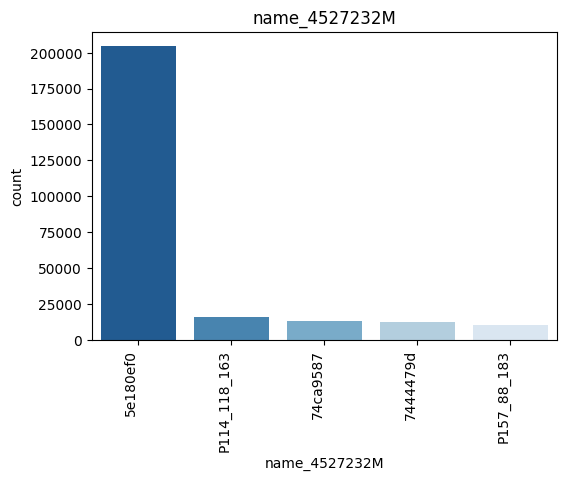

In [ ]:
print_info(df_tax_a1, df_tax_a1.columns[2])

## recorddate_4527225D
- Date of tax deduction record.
- 세금 공제 기록이 생성된 날짜

========== [recorddate_4527225D] ==========
데이터 타입: object
결측치 수, 결측치의 비율: 0, 0.0
최솟값: 2020-05-05T00:00:00.000000000 | 1
최댓값: 2019-12-14T00:00:00.000000000 | 49509
- - - - - - - - - - 
value_counts:
2019-12-14    49509
2019-12-13    47891
2020-01-11    40515
2020-01-12    38615
2019-12-01    33947
              ...  
2020-04-26        7
2020-05-03        5
2020-07-30        5
2020-05-12        2
2020-05-05        1
Name: recorddate_4527225D, Length: 397, dtype: int64
- - - - - - - - - - 


<ipython-input-2-e54903270e3f>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_datetime['count'], palette='Blues', )


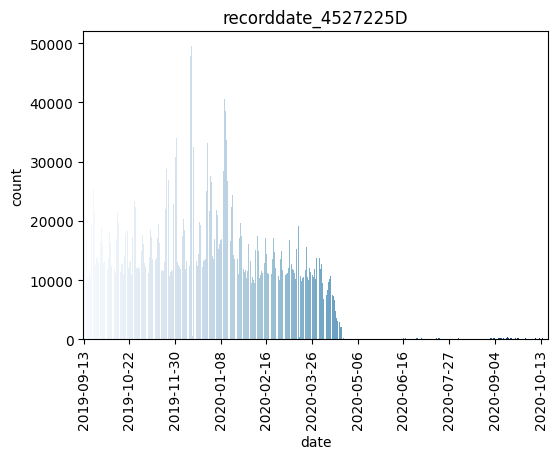

In [ ]:
print_info(df_tax_a1, df_tax_a1.columns[4])

# train_tax_registry_b_1

In [ ]:
df_tax_b1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107933 entries, 0 to 1107932
Data columns (total 5 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   case_id                 1107933 non-null  int64  
 1   amount_4917619A         1107933 non-null  float64
 2   deductiondate_4917603D  1107933 non-null  object 
 3   name_4917606M           1107933 non-null  object 
 4   num_group1              1107933 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 42.3+ MB


In [ ]:
df_tax_b1.case_id.value_counts()

1869915    101
2681835     83
1917900     70
229270      65
1863796     64
          ... 
1836919      1
1836908      1
1836906      1
1921830      1
258234       1
Name: case_id, Length: 150732, dtype: int64

## amount_4917619A
- Tax deductions amount tracked by the government registry.
- 정부 레지스트리에서 추적하는 세금 공제 금액

========== [amount_4917619A] ==========
데이터 타입: float64
결측치 수, 결측치의 비율: 0, 0.0
(null, 0, >0) = (0, 32, 1107901)
(min, max): (0.0, 344250.0)
평균값: 20104.96572377289
중간값: 13130.2


<ipython-input-2-e54903270e3f>:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(log_temp, palette='Blues_r', )


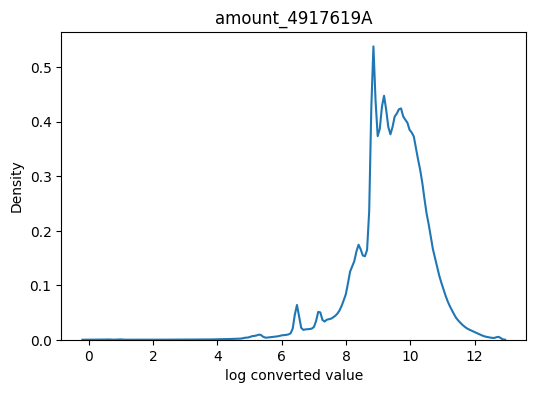

In [ ]:
print_info(df_tax_b1, df_tax_b1.columns[1])

## deductiondate_4917603D
- Tax deduction date.
- 세금 공제 날짜

========== [deductiondate_4917603D] ==========
데이터 타입: object
결측치 수, 결측치의 비율: 0, 0.0
최솟값: 2019-09-27T00:00:00.000000000 | 8
최댓값: 2020-04-03T00:00:00.000000000 | 20426
- - - - - - - - - - 
value_counts:
2020-04-03    20426
2020-04-09    19943
2020-05-06    16006
2020-06-04    15974
2020-06-05    15145
              ...  
2019-10-15       30
2019-10-02       29
2019-10-01       24
2019-09-30        9
2019-09-27        8
Name: deductiondate_4917603D, Length: 260, dtype: int64
- - - - - - - - - - 


<ipython-input-2-e54903270e3f>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_datetime['count'], palette='Blues', )


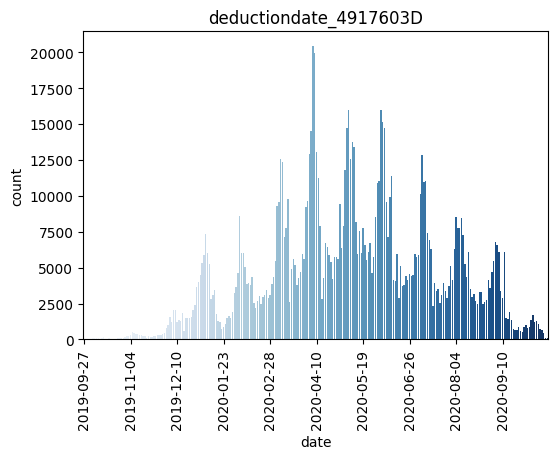

In [ ]:
print_info(df_tax_b1, df_tax_b1.columns[2])

## name_4917606M
- Name of employer.

========== [name_4917606M] ==========
데이터 타입: object
결측치 수, 결측치의 비율: 0, 0.0
(min, max): (00011206, ffff44de)
- - - - - - - - - - 
value_counts:
5e180ef0        85284
P114_118_163     7205
74ca9587         7153
7444479d         5173
3613fb71         4079
                ...  
db1dd3a7            1
98d0cb55            1
cb88bb9f            1
3bda9dc2            1
3ba7682e            1
Name: name_4917606M, Length: 55857, dtype: int64
- - - - - - - - - - 


<ipython-input-2-e54903270e3f>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col_name, order=df[col_name].value_counts()[:slice].index, palette='Blues_r', )


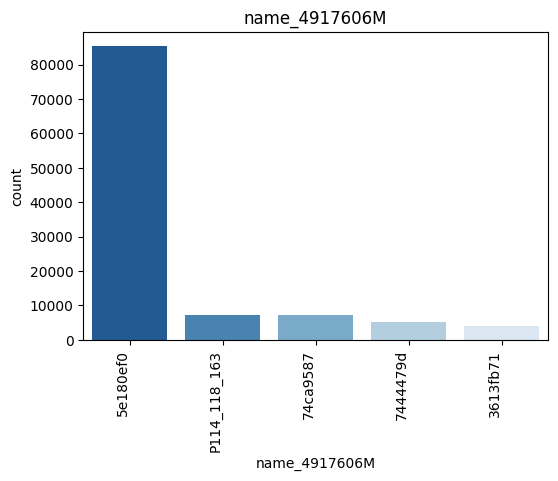

In [ ]:
print_info(df_tax_b1, df_tax_b1.columns[3])

# train_tax_registry_c_1

In [ ]:
df_tax_c1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3343800 entries, 0 to 3343799
Data columns (total 5 columns):
 #   Column               Dtype  
---  ------               -----  
 0   case_id              int64  
 1   employername_160M    object 
 2   num_group1           int64  
 3   pmtamount_36A        float64
 4   processingdate_168D  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 127.6+ MB


In [ ]:
df_tax_c1.case_id.value_counts()

608018     121
627764     121
700836     111
659955      99
1339712     69
          ... 
710928       1
710938       1
710950       1
162728       1
703938       1
Name: case_id, Length: 482265, dtype: int64

## employername_160M
 - Employer's name.

========== [employername_160M] ==========
데이터 타입: object
결측치 수, 결측치의 비율: 0, 0.0
(min, max): (000025c1, ffffaf43)
- - - - - - - - - - 
value_counts:
5e180ef0        209085
6a3d9351         18121
f10df922         14002
P114_118_163     11723
P157_88_183      10887
                 ...  
434dae4a             1
61dd8b9d             1
a7338c38             1
c91448a5             1
89fde8e1             1
Name: employername_160M, Length: 152835, dtype: int64
- - - - - - - - - - 


<ipython-input-2-e54903270e3f>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col_name, order=df[col_name].value_counts()[:slice].index, palette='Blues_r', )


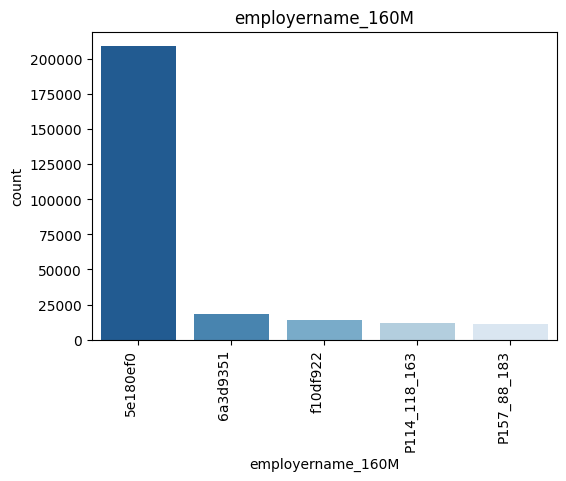

In [ ]:
print_info(df_tax_c1, df_tax_c1.columns[1])

## pmtamount_36A
- Tax deductions amount for credit bureau payments.
- 신용 기관 지불을 위한 세금 공제 금액

========== [pmtamount_36A] ==========
데이터 타입: float64
결측치 수, 결측치의 비율: 0, 0.0
(null, 0, >0) = (0, 28, 3343772)
(min, max): (0.0, 87115.6)
평균값: 2260.5373872849973
중간값: 1365.454


<ipython-input-2-e54903270e3f>:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(log_temp, palette='Blues_r', )


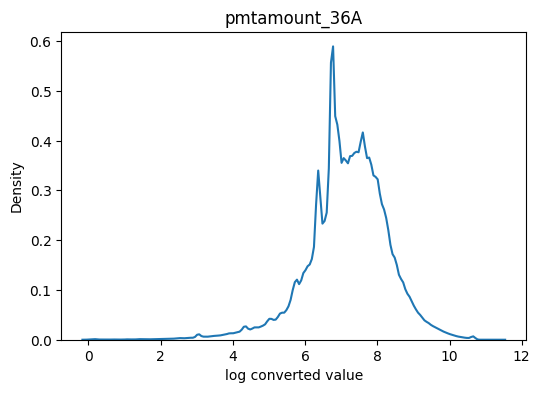

In [ ]:
print_info(df_tax_c1, df_tax_c1.columns[3])

## processingdate_168D
- Date when the tax deduction is processed.
- 세금 공제가 처리된 날짜를 기록

========== [processingdate_168D] ==========
데이터 타입: object
결측치 수, 결측치의 비율: 0, 0.0
최솟값: 2018-07-12T00:00:00.000000000 | 1
최댓값: 2019-04-02T00:00:00.000000000 | 43358
- - - - - - - - - - 
value_counts:
2019-04-02    43358
2019-04-03    41765
2019-03-08    41188
2019-03-07    39847
2019-01-07    39016
              ...  
2018-07-17       24
2018-07-16       24
2018-07-18       19
2018-07-11        2
2018-07-12        1
Name: processingdate_168D, Length: 325, dtype: int64
- - - - - - - - - - 


<ipython-input-2-e54903270e3f>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_datetime['count'], palette='Blues', )


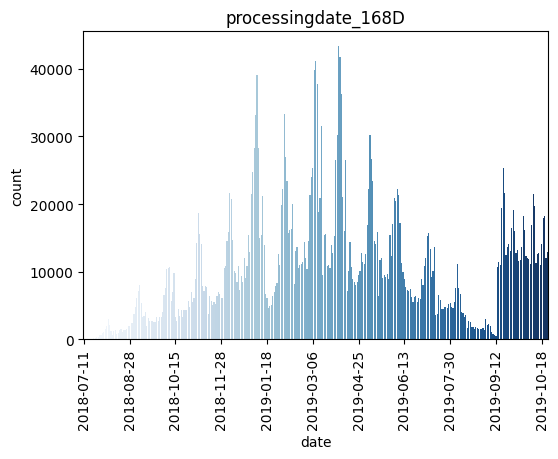

In [ ]:
print_info(df_tax_c1, df_tax_c1.columns[4])

# a / b / c 공통 유형 컬럼
- tax deduction_amount
  > amount_4527230A / amount_4917619A / pmtamount_36A
- tax date
  > recorddate_4527225D / deductiondate_4917603D / processingdate_168D
- employee name
  > name_4527232M / name_4917606M / employername_160M

=============amount_4527230A============
결측치 수, 결측치의 비율: 0, 0.0
(null, 0, >0) = (0, 165, 3275605)
(min, max): (0.0, 87115.6)
평균값: 2360.421375819258
중간값: 1400.0
=============amount_4917619A============
결측치 수, 결측치의 비율: 0, 0.0
(null, 0, >0) = (0, 32, 1107901)
(min, max): (0.0, 344250.0)
평균값: 20104.96572377289
중간값: 13130.2
=============pmtamount_36A============
결측치 수, 결측치의 비율: 0, 0.0
(null, 0, >0) = (0, 28, 3343772)
(min, max): (0.0, 87115.6)
평균값: 2260.5373872849973
중간값: 1365.454


<ipython-input-20-9b93e4258c8a>:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(temp1, palette='Blues_r', )
<ipython-input-20-9b93e4258c8a>:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(temp2, palette='Blues_r', )
<ipython-input-20-9b93e4258c8a>:34: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(temp3, palette='Blues_r', )


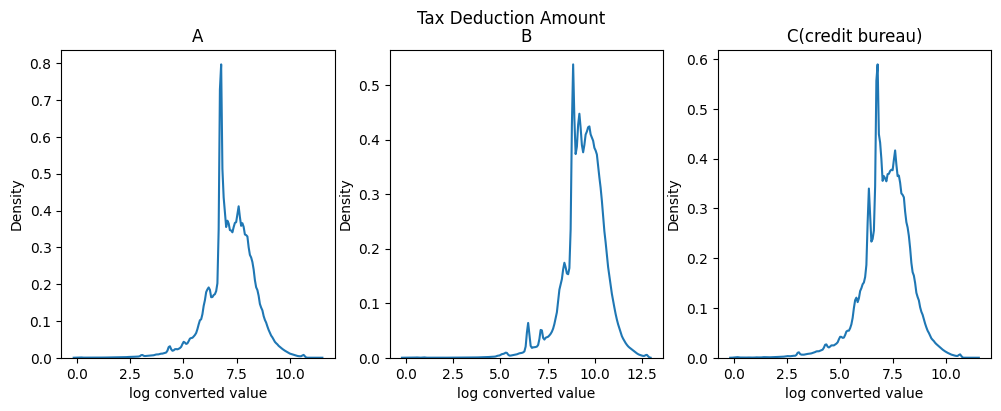

In [ ]:
# tax deduction amount

# text
for df_col in [df_tax_a1.amount_4527230A, df_tax_b1.amount_4917619A, df_tax_c1.pmtamount_36A]:
    print(f'============={df_col.name}============')
    print(f'결측치 수, 결측치의 비율: {df_col.isna().sum()}, {(df_col.isna().sum() / df_col.shape[0] * 100)}')
    print(f"(null, 0, >0) = {df_col.isna().sum(), (df_col == 0.0).sum(), (df_col > 0.0).sum()}")
    print(f'(min, max): ({df_col.dropna().min()}, {df_col.dropna().max()})')
    print(f'평균값: {df_col.dropna().mean()}')
    print(f'중간값: {df_col.dropna().median()}')



# graph
plt.figure(figsize=(12, 4))

# a
plt.subplot(1, 3, 1)
temp1 = np.log1p(df_tax_a1.amount_4527230A)
sns.kdeplot(temp1, palette='Blues_r', )
plt.xlabel('log converted value')
plt.title('A')

# b
plt.subplot(1, 3, 2)
temp2 = np.log1p(df_tax_b1.amount_4917619A)
sns.kdeplot(temp2, palette='Blues_r', )
plt.xlabel('log converted value')
plt.title('B')

# c
plt.subplot(1, 3, 3)
temp3 = np.log1p(df_tax_c1.pmtamount_36A)
sns.kdeplot(temp3, palette='Blues_r', )
plt.xlabel('log converted value')
plt.title('C(credit bureau)')

plt.suptitle('Tax Deduction Amount')

plt.show()

In [ ]:
a1_order = df_tax_a1[['case_id','num_group1', 'amount_4527230A', 'recorddate_4527225D', 'name_4527232M']]
b1_order = df_tax_b1[['case_id','num_group1',"amount_4917619A", "deductiondate_4917603D", "name_4917606M"]]
c1_order = df_tax_c1[['case_id','num_group1', "pmtamount_36A", "processingdate_168D", "employername_160M"]]


a1_case_id = a1_order['case_id']
b1_case_id = b1_order['case_id']
c1_case_id = c1_order['case_id']

# 중복 case_id 있는지 확인
overlap_a_b = pd.merge(a1_order, b1_order, on='case_id', how='inner')
overlap_a_c = pd.merge(a1_order, c1_order, on='case_id', how='inner')
overlap_b_c = pd.merge(b1_order, c1_order, on='case_id', how='inner')



In [ ]:
len(overlap_a_b.case_id.unique()), len(df_tax_a1.case_id.unique()), len(df_tax_b1.case_id.unique())

(4246, 457934, 150732)

In [ ]:
left_a_b = pd.merge(a1_order, b1_order, on='case_id', how='left')
right_a_b = pd.merge(a1_order, b1_order, on='case_id', how='right')
left_a_b

,case_id,num_group1_x,amount_4527230A,recorddate_4527225D,name_4527232M,num_group1_y,amount_4917619A,deductiondate_4917603D,name_4917606M
0,28631,2,1946.0000,2019-09-13,f980a1ea,NaN,NaN,NaN,NaN
1,28631,3,711.0000,2019-09-13,f980a1ea,NaN,NaN,NaN,NaN
2,28631,0,3616.4001,2019-09-13,f980a1ea,NaN,NaN,NaN,NaN
3,28631,1,2600.0000,2019-09-13,f980a1ea,NaN,NaN,NaN,NaN
4,28632,5,2564.0000,2019-09-13,5f9b74f5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3515778,2702290,2,850.0000,2020-10-13,94721311,2.0,6885.0,2020-08-20,94721311
3515779,2702290,2,850.0000,2020-10-13,94721311,0.0,6885.0,2020-07-14,94721311
3515780,2702290,0,850.0000,2020-10-13,94721311,1.0,6885.0,2020-07-14,94721311
3515781,2702290,0,850.0000,2020-10-13,94721311,2.0,6885.0,2020-08-20,94721311


In [ ]:
condition = (right_a_b.num_group1_x.notnull()) & (right_a_b.num_group1_y.isnull())
right_a_b[condition]

,case_id,num_group1_x,amount_4527230A,recorddate_4527225D,name_4527232M,num_group1_y,amount_4917619A,deductiondate_4917603D,name_4917606M


In [ ]:
len(overlap_a_c.case_id.unique()), len(df_tax_a1.case_id.unique()), len(df_tax_c1.case_id.unique())

(82920, 457934, 482265)

In [ ]:
overlap_a_b.head(50)

,case_id,num_group1_x,amount_4527230A,recorddate_4527225D,name_4527232M,num_group1_y,amount_4917619A,deductiondate_4917603D,name_4917606M
0,49435,7,850.0,2020-03-26,6b730375,7,6885.0,2019-10-16,6b730375
1,49435,7,850.0,2020-03-26,6b730375,1,6885.0,2019-10-16,6b730375
2,49435,7,850.0,2020-03-26,6b730375,8,6885.0,2019-10-16,6b730375
3,49435,7,850.0,2020-03-26,6b730375,3,6885.0,2019-10-16,6b730375
4,49435,7,850.0,2020-03-26,6b730375,4,6885.0,2019-10-16,6b730375
5,49435,7,850.0,2020-03-26,6b730375,2,6885.0,2019-10-16,6b730375
6,49435,7,850.0,2020-03-26,6b730375,6,6885.0,2019-10-16,6b730375
7,49435,7,850.0,2020-03-26,6b730375,5,6885.0,2019-10-16,6b730375
8,49435,7,850.0,2020-03-26,6b730375,9,6885.0,2019-10-16,6b730375
9,49435,7,850.0,2020-03-26,6b730375,0,6885.0,2019-10-16,6b730375


In [ ]:
overlap_a_b_group = overlap_a_b.groupby(['case_id','num_group1_x']).agg({
    'num_group1_y': 'count'
})
overlap_a_b_group.head(30)

num_group1_y
case_id num_group1_x              
49435   0                       11
        1                       11
        2                       11
        3                       11
        4                       11
        5                       11
        6                       11
        7                       11
        8                       11
        9                       11
        10                      11
49490   0                        6
        1                        6
        2                        6
        3                        6
        4                        6
        5                        6
49526   0                        2
        1                        2
49563   0                       11
        1                       11
        2                       11
        3                       11
        4                       11
        5                       11
        6                       11
        7                       11
        8                       11
        9                       11
        10                      11

In [ ]:
overlap_a_c

,case_id,num_group1_x,amount_4527230A,recorddate_4527225D,name_4527232M,num_group1_y,pmtamount_36A,processingdate_168D,employername_160M
0,28631,2,1946.00000,2019-09-13,f980a1ea,2,2600.00000,2019-06-06,f980a1ea
1,28631,2,1946.00000,2019-09-13,f980a1ea,3,3616.40010,2019-05-09,f980a1ea
2,28631,2,1946.00000,2019-09-13,f980a1ea,0,711.00000,2019-09-09,f980a1ea
3,28631,2,1946.00000,2019-09-13,f980a1ea,1,1946.00000,2019-07-09,f980a1ea
4,28631,3,711.00000,2019-09-13,f980a1ea,2,2600.00000,2019-06-06,f980a1ea
...,...,...,...,...,...,...,...,...,...
5198300,2629815,7,301.80002,2019-10-22,378c3e37,10,1961.20010,2019-10-22,378c3e37
5198301,2629815,7,301.80002,2019-10-22,378c3e37,1,1961.20010,2019-10-22,378c3e37
5198302,2629815,7,301.80002,2019-10-22,378c3e37,6,1961.20010,2019-10-22,378c3e37
5198303,2629815,7,301.80002,2019-10-22,378c3e37,3,1961.20010,2019-10-22,378c3e37


In [ ]:
overlap_a_c_group = overlap_a_c.groupby(['case_id','num_group1_x']).agg({
    'num_group1_y': 'count'
})
overlap_a_c_group.head(30)

num_group1_y
case_id num_group1_x              
28631   0                        4
        1                        4
        2                        4
        3                        4
28632   0                       10
        1                       10
        2                       10
        3                       10
        4                       10
        5                       10
        6                       10
        7                       10
        8                       10
        9                       10
28633   0                        1
28635   0                        2
        1                        2
28636   0                        7
        1                        7
        2                        7
        3                        7
        4                        7
        5                        7
        6                        7
28641   0                        9
        1                        9
        2                        9
        3                        9
        4                        9
        5                        9

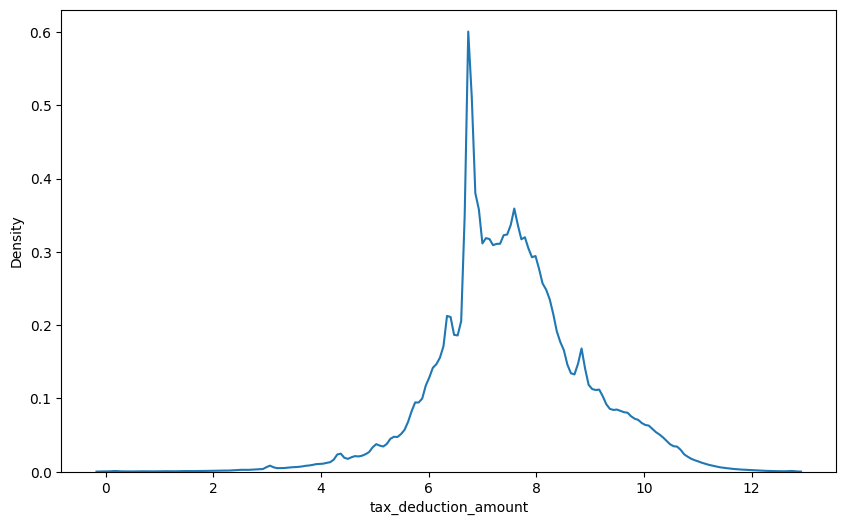

In [ ]:
a1_order = df_tax_a1[['case_id','num_group1', 'amount_4527230A', 'recorddate_4527225D', 'name_4527232M']]
b1_order = df_tax_b1[['case_id','num_group1',"amount_4917619A", "deductiondate_4917603D", "name_4917606M"]]
c1_order = df_tax_c1[['case_id','num_group1', "pmtamount_36A", "processingdate_168D", "employername_160M"]]


a1_order.columns = ['case_id', 'num_group1', 'tax_deduction_amount', 'tax_date', 'employee_name']
b1_order.columns = ['case_id','num_group1','tax_deduction_amount', 'tax_date', 'employee_name']
c1_order.columns = ['case_id','num_group1','tax_deduction_amount', 'tax_date', 'employee_name']



df_merged = pd.concat([a1_order, b1_order, c1_order], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.kdeplot(np.log1p(df_merged.tax_deduction_amount))
plt.show()


In [ ]:
df_merged

,case_id,num_group1,tax_deduction_amount,tax_date,employee_name
0,28631,2,1946.00000,2019-09-13,f980a1ea
1,28631,3,711.00000,2019-09-13,f980a1ea
2,28631,0,3616.40010,2019-09-13,f980a1ea
3,28631,1,2600.00000,2019-09-13,f980a1ea
4,28632,5,2564.00000,2019-09-13,5f9b74f5
...,...,...,...,...,...
7727498,2629815,10,1961.20010,2019-10-22,378c3e37
7727499,2629815,1,1961.20010,2019-10-22,378c3e37
7727500,2629815,6,1961.20010,2019-10-22,378c3e37
7727501,2629815,3,1961.20010,2019-10-22,378c3e37


In [ ]:
#df_groupby = pd.pivot(data=df_merged, index='case_id', columns='tax_date',values=['tax_deduction_amount', 'tax_date', 'employee_name'])
df_groupby = df_merged.groupby(['case_id', 'num_group1']).agg({
    'tax_deduction_amount': 'mean',
    'employee_name': 'first',
    'tax_date': 'last',
}).reset_index()

In [ ]:
# num_group1 - This is an indexing column used for the historical records of case_id
# tax_date 의 최신 날짜와 다르지만, tax_date(이루어진 날짜, 기록날짜 등 약간의 의미 차이 존재)
# num_group1 기준 max값을 case_id의 대푯값으로 설정
# 'case_id'별로 'num_group1'의 최대값 계산

max_num_group1 = df_merged.groupby('case_id')['num_group1'].max().reset_index()

# 'case_id'와 'num_group1'을 기준으로 최대값을 가지는 행 선택
df_max_group1 = df_merged.merge(max_num_group1, on=['case_id', 'num_group1'], how='inner')


df_result = df_max_group1.groupby(['case_id', 'num_group1']).agg({
    'tax_deduction_amount': 'mean',
    'employee_name': 'first',
    'tax_date': 'last'
}).reset_index()

print(df_result)

         case_id  num_group1  tax_deduction_amount employee_name    tax_date
0            357           5            1100.00000      c91b12ff  2018-08-08
1            381           5             690.60004      8026f2a0  2018-08-07
2            388           5            2708.40010      34cb7f48  2018-08-02
3            405           5            1649.80000      6771878b  2018-08-13
4            409           6             997.75995      1d197dc0  2018-08-06
...          ...         ...                   ...           ...         ...
1003760  2703443           5           56100.00000      6d3e6416  2020-09-04
1003761  2703445           4           10110.40000      614a1950  2020-09-04
1003762  2703448           5            8100.00000      ded265ee  2020-09-30
1003763  2703449           7            3270.80000      5e180ef0  2020-09-25
1003764  2703452           5           10003.60100      6b791858  2020-10-01

[1003765 rows x 5 columns]


In [ ]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003765 entries, 0 to 1003764
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   case_id               1003765 non-null  int64  
 1   num_group1            1003765 non-null  int64  
 2   tax_deduction_amount  1003765 non-null  float64
 3   employee_name         1003765 non-null  object 
 4   tax_date              1003765 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 38.3+ MB
